In [2]:
import numpy as np
from tqdm import tqdm
from astropy.io import fits
from astropy.wcs import WCS
import jax.numpy as jnp
import os
from perch.perch_ph import PH
from perch.perch_structures import Structures
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
#from persim import PersImage
from persim import PersistenceImager
from PIL import Image
from skimage import color
from skimage import io
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

# Load data

In [3]:
gz_img_ids = pd.read_csv('/Users/toneill/Downloads/gz2_filename_mapping.csv')
gz_img_ids.columns = ['dr7objid', 'sample', 'asset_id']

gz_tab = Table.read('/Users/toneill/Downloads/gz2_hart16.fits').to_pandas()
gz_df = pd.merge(gz_img_ids,gz_tab,on='dr7objid')
gz_df.columns = np.where(gz_df.columns=='gz2_class' , 'gz2class',gz_df.columns)
gz_df['gz2class'] = [i.decode() for i in gz_df['gz2class'].values]

has_arms = (gz_df['gz2class'].str.contains('1') +\
            gz_df['gz2class'].str.contains('2') +\
            gz_df['gz2class'].str.contains('3') +\
           gz_df['gz2class'].str.contains('4') + \
            (gz_df['gz2class'].str.find('+') > 0)#+ \
            #(gz_df['gz2class'].str.find('?') > 0)
            )
gz_df['spiral'] =gz_df['gz2class'].str.startswith('S') & has_arms
gz_df['ell'] =gz_df['gz2class'].str.startswith('Er')
sell_df = gz_df[gz_df['spiral'] + gz_df['ell']].reset_index()

ddir = '/Users/toneill/Downloads/galaxy_zoo_images/'
file_exists = [os.path.isfile(f"{ddir}{sell_df['asset_id'].values[i]}.jpg") for i in range(len(sell_df))]
sell_df = sell_df[file_exists].reset_index(drop=True)

#train_df =sell_df.sample(int(len(sell_df)/5))
train_df = sell_df
train_df['class'] = np.where(train_df['spiral'],1,0)

# Perch Calculation for each galaxy

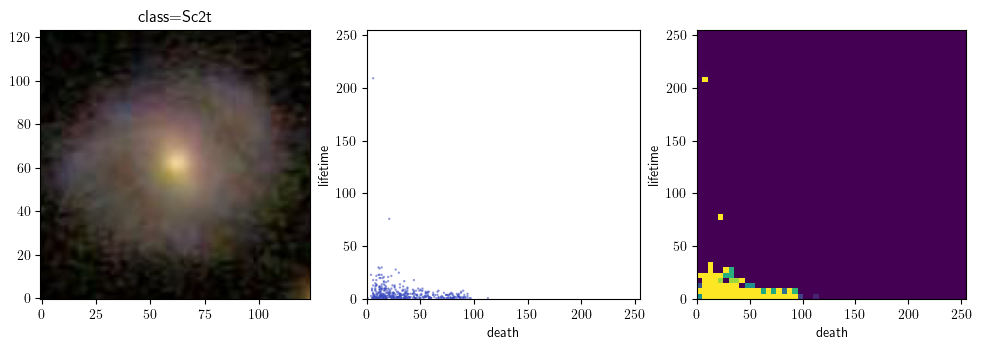

In [27]:
### plot example galaxy

show_plot = True
df_use = train_df

trim_bord = 150

gal_id = df_use['asset_id'].values[np.random.randint(0,len(df_use),1)][0]
img_use = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')[trim_bord:-trim_bord,trim_bord:-trim_bord]
hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))
pimgr.kernel_params = {'sigma': .1}
per_img0 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==0])

if show_plot:
        img = mpimg.imread(f'{ddir}{gal_id}.jpg')
        img_crop = img[trim_bord:-trim_bord,trim_bord:-trim_bord,:]

        fig, [ax1,ax2,ax3]  = plt.subplots(1,3,figsize=(12,3.5))
        ax1.imshow(img_crop,origin='lower')
        ax1.set_title(f"class={df_use['gz2class'].values[i]}")

        ax2.scatter(hom.generators[:,2],hom.generators[:,1]-hom.generators[:,2],#s=1,
                    c=hom.generators[:,0],s=0.5,alpha=0.5,cmap='coolwarm')
        ax2.set_xlim(0,255)
        ax2.set_ylim(0,255)
        ax2.set_xlabel('death')
        ax2.set_ylabel('lifetime')

        ax3.imshow((per_img0).T,origin='lower',extent=[0,255,0,255],vmax=10)#2,vmin=-10)#,origin='lower')#,vmax=1)#,origin='lower')#,vmax=1)#,vmin=-3)
        ax3.set_xlabel('death')
        ax3.set_ylabel('lifetime')


In [4]:
### run on all galaxies

save_per_imgs = []
flat_imgs = []
df_use = train_df
trim_bord = 150

i = 0
show_plot = False

t1 = time.time()
pbar = tqdm(total=len(df_use), unit='galaxies')
for gal_id in df_use['asset_id']:#

    img_use = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')[trim_bord:-trim_bord,trim_bord:-trim_bord]

    hom = PH.compute_hom(img_use,verbose=False,engine='C',flip_data=True,max_Hi=0)
    
    pimgr = PersistenceImager(pixel_size=5,birth_range=(0,255),pers_range=(0,255))
    pimgr.kernel_params = {'sigma': .1}
    #per_img = pimgr.transform(hom.generators[:,[2,1]])
    per_img0 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==0])
    #per_img1 = pimgr.transform(hom.generators[:,[2,1]][hom.generators[:,0]==1])

    #save_per_imgs.append(per_img)
    #flat_imgs.append(np.append(per_img0.flatten(),per_img1.flatten()))
    flat_imgs.append(per_img0.flatten())

    if show_plot:
        img = mpimg.imread(f'{ddir}{gal_id}.jpg')
        img_crop = img[trim_bord:-trim_bord,trim_bord:-trim_bord,:]

        fig, [ax1,ax2,ax3]  = plt.subplots(1,3,figsize=(12,3.5))
        ax1.imshow(img_crop,origin='lower')
        ax1.set_title(f"class={df_use['gz2class'].values[i]}")

        ax2.scatter(hom.generators[:,2],hom.generators[:,1]-hom.generators[:,2],#s=1,
                    c=hom.generators[:,0],s=0.5,alpha=0.5,cmap='coolwarm')
        ax2.set_xlim(0,255)
        ax2.set_ylim(0,255)
        ax2.set_xlabel('death')
        ax2.set_ylabel('lifetime')

        ax3.imshow(np.log10(per_img0).T,origin='lower',extent=[0,255,0,255],vmax=2,vmin=-10)#,origin='lower')#,vmax=1)#,origin='lower')#,vmax=1)#,vmin=-3)
        ax3.set_xlabel('death')
        ax3.set_ylabel('lifetime')

    i += 1

    pbar.update(1)

t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')
print(f'{(t2 - t1)/len(df_use):.5f} s/galaxy')
print(f"{((t2 - t1)/len(df_use)*np.sum(gz_df['spiral'] + gz_df['ell']))/60:.2f} minutes full dataset")

100%|█████████▉| 94379/94381 [12:24<00:00, 113.83galaxies/s]

744.60 s elapsed
0.00789 s/galaxy
12.41 minutes full dataset


# Visualize mean PIs for each class

In [7]:
flat_ar = np.array(flat_imgs)
npix = np.product(pimgr.resolution)
h0_imgs = np.array([flat_ar[i,0:int(npix)].reshape(pimgr.resolution) for i in range(np.shape(flat_ar)[0])])

spiral_per_img = np.mean(np.array(h0_imgs)[train_df['class']==1],axis=0)
ell_per_img = np.mean(np.array(h0_imgs)[train_df['class']==0],axis=0)
diff_per_classes = spiral_per_img-ell_per_img

/var/folders/b2/7lt3z5q170x2xkhr6srvvm_r0000gn/T/ipykernel_2062/717124563.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(spiral_per_img).T,vmin=0,vmax=2,origin='lower',extent=[0,255,0,255])


Text(0, 0.5, 'lifetime')

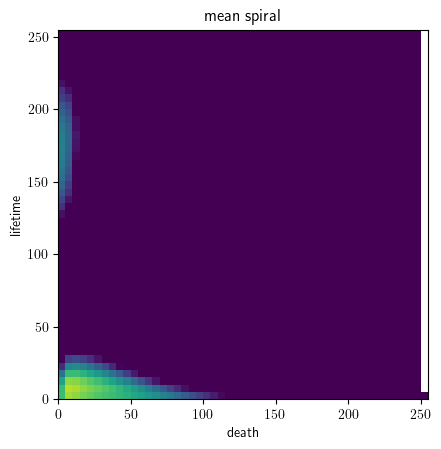

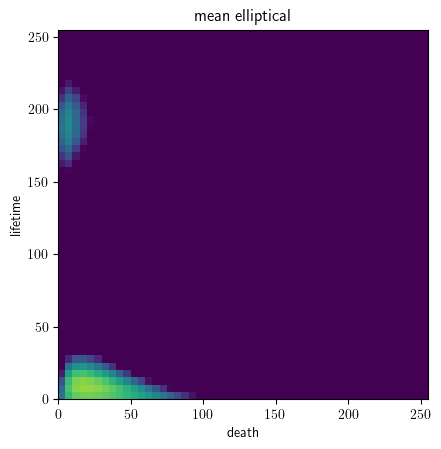

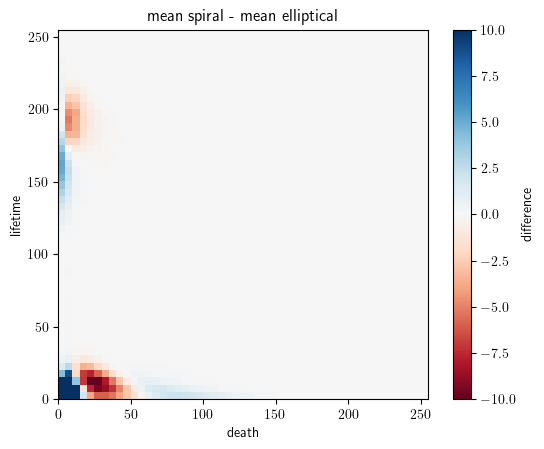

In [8]:
plt.figure()
plt.imshow(np.log10(spiral_per_img).T,vmin=0,vmax=2,origin='lower',extent=[0,255,0,255])
plt.title('mean spiral')
plt.xlabel('death')
plt.ylabel('lifetime')

plt.figure()
plt.imshow(np.log10(ell_per_img).T,vmin=0,vmax=2,origin='lower',extent=[0,255,0,255])
plt.title('mean elliptical')
plt.xlabel('death')
plt.ylabel('lifetime')

plt.figure()
plt.imshow(diff_per_classes.T,cmap='RdBu',vmax=10,vmin=-10,origin='lower',extent=[0,255,0,255])
plt.title('mean spiral - mean elliptical')
plt.colorbar(label='difference')
plt.xlabel('death')
plt.ylabel('lifetime')

# Classify

In [9]:
flat_array = flat_imgs
labels = train_df['class'].values

X_train, X_test, y_train, y_test = train_test_split(flat_array, labels, train_size=0.70)#, random_state=42)

In [10]:
t1 = time.time()
clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(int(np.shape(flat_array)[1]/10), int(np.shape(flat_array)[1]/100)),max_iter=500)
clf.fit(X_train, y_train)
t2 = time.time()
print(f'{t2-t1:.2f} s elapsed')
print(f'training accuracy: {clf.score(X_train,y_train)*100:.2f}%')
print(f'training accuracy: {clf.score(X_test,y_test)*100:.2f}%')

997.84 s elapsed
training accuracy: 99.15%
training accuracy: 82.56%


Text(0.5, 1.0, 'Test set')

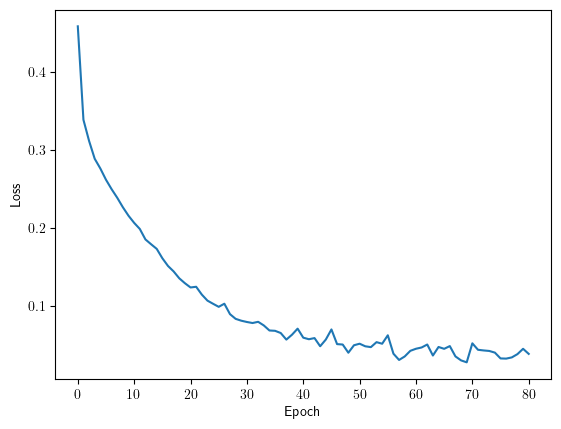

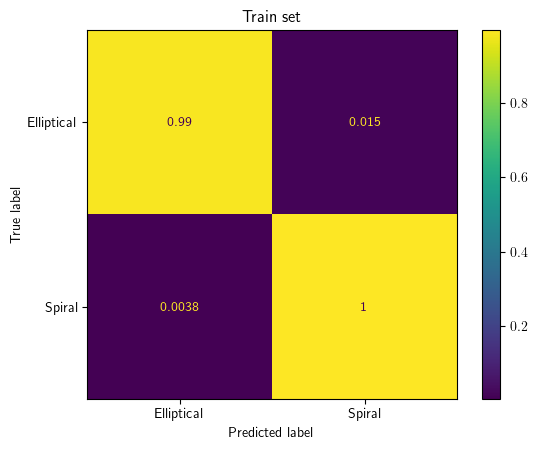

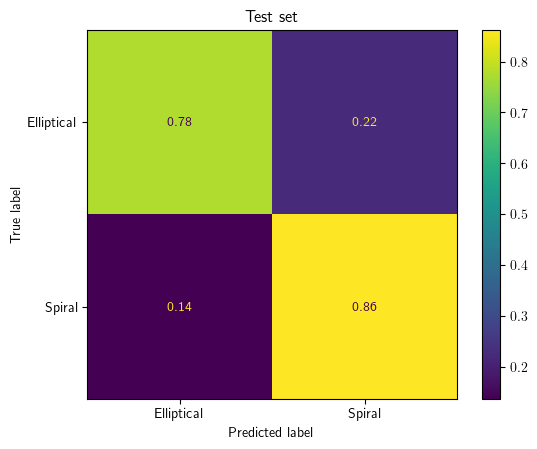

In [11]:
loss_epoch = clf.loss_curve_
plt.figure()
plt.plot(np.arange(len(loss_epoch)),loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

pred_class = clf.predict(X_train)
labels_plot = y_train
cm = confusion_matrix(labels_plot,pred_class,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Elliptical','Spiral'])
disp.plot()
plt.title('Train set')

pred_class = clf.predict(X_test)
labels_plot = y_test
cm = confusion_matrix(labels_plot,pred_class,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Elliptical','Spiral'])
disp.plot()
plt.title('Test set')

# Visualize correctly/incorrectly classified

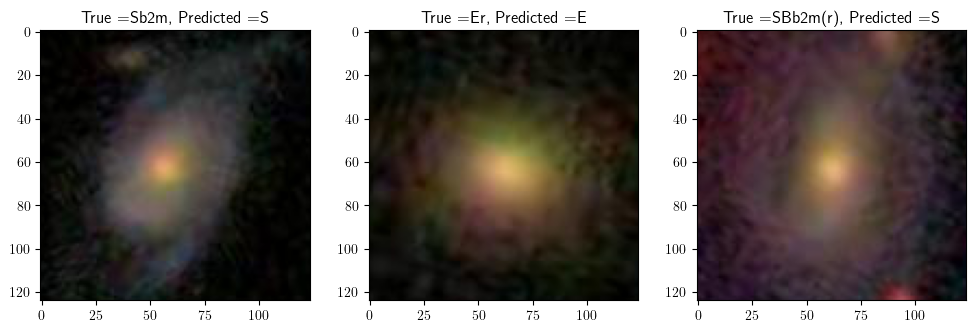

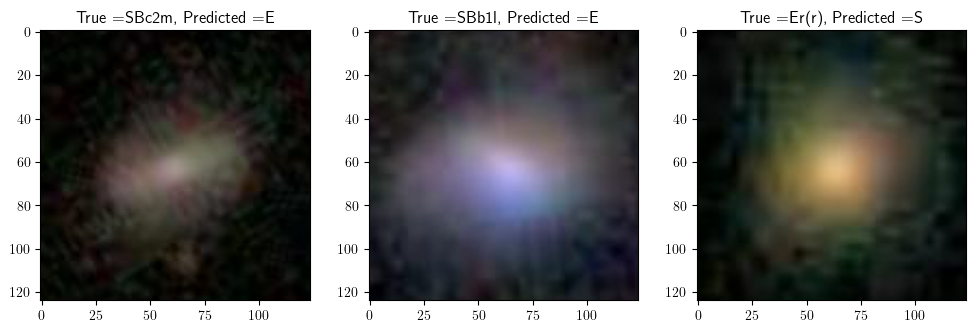

In [16]:
pred_dict = {0:'E',1:'S'}

pred_class = clf.predict(flat_array)
labels_plot = labels

good_class, = np.where(pred_class == labels_plot)
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
axs.ravel()
good_plot = good_class[np.random.randint(0,len(good_class),3)]
for i in range(len(good_plot)):
    ax = axs[i]
    gal_id = train_df['asset_id'].values[good_plot[i]]
    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    ax.imshow(img[trim_bord:-trim_bord, trim_bord:-trim_bord, :])
    ax.set_title(f"True ={train_df['gz2class'].values[good_plot[i]]}, Predicted ={pred_dict[pred_class[good_plot[i]]]}")

miss_class, = np.where(pred_class != labels_plot)
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
axs.ravel()
miss_plot = miss_class[np.random.randint(0,len(miss_class),3)]
for i in range(len(miss_plot)):
    ax = axs[i]
    gal_id = train_df['asset_id'].values[miss_plot[i]]
    img = mpimg.imread(f'{ddir}{gal_id}.jpg')
    #img = np.array(Image.open(f'{ddir}{gal_id}.jpg').convert('L'),dtype='float32')#[trim_bord:-trim_bord,trim_bord:-trim_bord]
    ax.imshow(img[trim_bord:-trim_bord, trim_bord:-trim_bord])#,cmap='Greys_r')
    ax.set_title(f"True ={train_df['gz2class'].values[miss_plot[i]]}, Predicted ={pred_dict[pred_class[miss_plot[i]]]}")

# Assess classification performance by galaxy type


/var/folders/b2/7lt3z5q170x2xkhr6srvvm_r0000gn/T/ipykernel_2062/802052804.py:9: RuntimeWarning: invalid value encountered in scalar divide
  nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)


Text(0, 0.5, 'Accuracy')

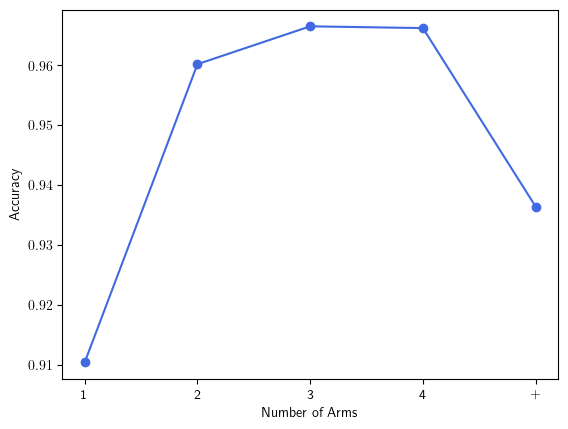

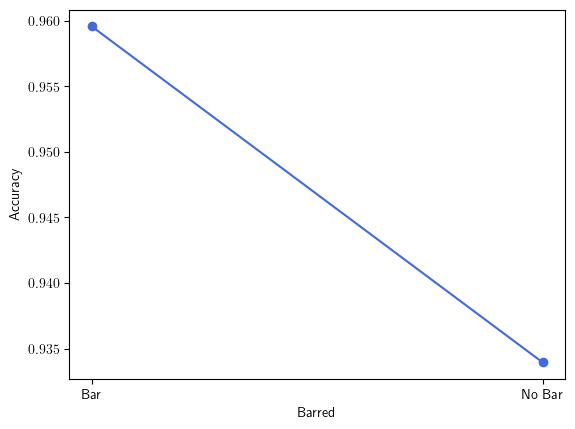

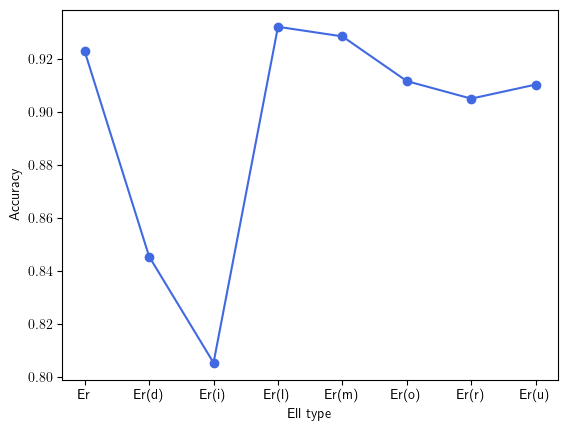

In [17]:
result_pred = pred_class == labels_plot

### classification by spiral arm type
narm_strs = ['1','2','3','4','+','?']
correct_narm = np.full(len(narm_strs),np.nan)
for i in range(len(narm_strs)):
    narm = narm_strs[i]
    narm_bool = train_df['gz2class'].str.find(narm) > 0
    nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)
    correct_narm[i] = nfrac_yes

plt.figure()
plt.plot(narm_strs,correct_narm,marker='o',c='royalblue')
plt.xlabel('Number of Arms')
plt.ylabel('Accuracy')

### classification by bar
has_bar = train_df['gz2class'].str.startswith('SB')
correct_bar = np.full(2,np.nan)
for i in range(len(correct_bar)):
    if i == 0:
        narm_bool = has_bar
    if i == 1:
        narm_bool = ~has_bar
    nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)
    correct_bar[i] = nfrac_yes

plt.figure()
plt.plot(['Bar','No Bar'],correct_bar,marker='o',c='royalblue')
plt.xlabel('Barred')
plt.ylabel('Accuracy')

### classification by elliptical type
gal_types = np.unique(train_df['gz2class'])
ell_types = gal_types[np.where([gal_types[i].startswith('Er') for i in range(len(gal_types))])]
correct_ell = np.full(len(ell_types),np.nan)
for i in range(len(ell_types)):
    etype = ell_types[i]
    narm_bool = train_df['gz2class']==etype
    nfrac_yes = np.sum(result_pred[narm_bool])/np.sum(narm_bool)
    correct_ell[i] = nfrac_yes

plt.figure()
plt.plot(ell_types,correct_ell,marker='o',c='royalblue')
plt.xlabel('Ell type')
plt.ylabel('Accuracy')